In [1]:
# python
from tqdm.notebook import tqdm
import sys
import os
import importlib
# columnar analysis
import awkward as ak
import mplhep as hep
import numpy as np
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
# local
sys.path.insert(1, os.path.join(sys.path[0], '../../..')) # fixme: there must be a better way to handle this...
from sidm.tools import sidm_processor, utilities
# always reload local modules to pick up changes during development
importlib.reload(sidm_processor)
importlib.reload(utilities)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()
%matplotlib inline

In [2]:
def invariantMass(pt1, pt2, phi1, phi2, eta1, eta2):
    M2 = 2*pt1*pt2*(np.cosh(eta1-eta2)-np.cos(phi1-phi2))
    return np.sqrt(M2)

In [3]:
def deltaR(genetas, eta, genphis, phi):
    pi = np.pi
    return np.sqrt((genetas-eta)**2+((genphis-phi+pi)%(2*pi)-pi)**2)

In [4]:
def invMassGenMatchPhotonGenElectron(Photons, genElectrons):
    electronCut = (ak.num(genElectrons)==2)
    genElectrons = genElectrons[electronCut]
    evtMatchPhotons = Photons[electronCut]
    evtMatchElectrons = Electrons[electronCut]
    nonEmpty = ak.num(evtMatchPhotons) > 0
    evtMatchPhotons = evtMatchPhotons[nonEmpty]
    genElectrons = genElectrons[nonEmpty]
    photon_genpartidx_deltar=[]
    genpart_eta = genElectrons.eta
    genpart_phi = genElectrons.phi
    photon_eta = evtMatchPhotons.eta
    photon_phi = evtMatchPhotons.phi
    for genetas, genphis, etas, phis in zip(genpart_eta, genpart_phi, photon_eta, photon_phi):
        idx=[]
        for eta, phi in zip(etas, phis):
            deltar=deltaR(genetas, eta, genphis, phi)
            #print(deltar)
            if ak.min(deltar)<0.011:
                idx.append(ak.argmin(deltar))
            else:
                idx.append(-1)
        photon_genpartidx_deltar.append(idx)
    masking_genmatched=(ak.Array(photon_genpartidx_deltar)!=-1)
    genMatchedPhotons = evtMatchPhotons[masking_genmatched]
    genMatchedGenElectrons = genElectrons[masking_genmatched]
    pts = []
    etas = []
    phis = []
    for i in range(len(photon_genpartidx_deltar)):
        if len(photon_genpartidx_deltar[i]) == 1:
            if photon_genpartidx_deltar[i][0] == -1: continue
            if photon_genpartidx_deltar[i][0] == 0:
                pts.append([genMatchedPhotons[i].pt[0], genElectrons[i].pt[1]])
                etas.append([genMatchedPhotons[i].eta[0], genElectrons[i].eta[1]])
                phis.append([genMatchedPhotons[i].phi[0], genElectrons[i].phi[1]])
            if photon_genpartidx_deltar[i][0] == 1:
                pts.append([genElectrons[i].pt[0], genMatchedPhotons[i].pt[0]])
                etas.append([genElectrons[i].eta[0], genMatchedPhotons[i].eta[0]])
                phis.append([genElectrons[i].eta[0], genMatchedPhotons[i].eta[0]])
    masses = []
    for i in range(len(etas)):
        masses.append(invariantMass(pts[i][0], pts[i][1], phis[i][0], phis[i][1], etas[i][0], etas[i][1]))
    masses = np.array(masses)
    return masses

In [5]:
samples = [
    "2Mu2E_500GeV_5p0GeV_0p8mm",
]
fileset = utilities.make_fileset(samples, "llpNanoAOD_v2", max_files=1, location_cfg="signal_v6.yaml")

In [6]:
events = {}

for i in tqdm(samples):
    fname = fileset[i][0]
    print(fname)
    events[i] = NanoEventsFactory.from_root(
        fname,
        schemaclass=NanoAODSchema,
    ).events()

  0%|          | 0/1 [00:00<?, ?it/s]

root://xcache//store/group/lpcmetx/SIDM/ULSignalSamples/2018_v6/LLPNanoAOD_V2/SIDM_BsTo2DpTo2Mu2e_MBs-500_MDp-5p0_ctau-0p8/LLPnanoAODv2/SIDM_BsTo2DpTo2Mu2e_MBs-500_MDp-5p0_ctau-0p8_part-0.root


Text(0.5, 1.0, '2Mu2E_500GeV_5p0GeV_0p8mm')

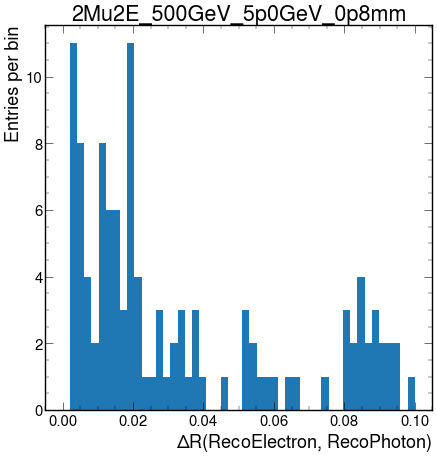

In [7]:
'''
from selections
electrons: &electrons_ljsource_cuts
      - "pT > 10 GeV"
      - "|eta| < 2.4"
      - "looseID"
photons:
      - "pT > 20 GeV"
      - "eta"
      - "looseID"
      - "pixelSeed"
      - "electronVeto"
'''

Electrons = events['2Mu2E_500GeV_5p0GeV_0p8mm']['Electron']
Photons = events['2Mu2E_500GeV_5p0GeV_0p8mm']['Photon']

#Electron Cuts
recoElecPT = (Electrons.pt > 10)
recoElecEta = (abs(Electrons.eta) < 2.4)
recoElecLoose = (Electrons.cutBased >= 2)
recoElecCut = recoElecPT & recoElecEta & recoElecLoose

#Photon Cuts
recoPhotonPT = (Photons.pt > 20)
recoPhotonEta = (Photons.isScEtaEB | Photons.isScEtaEE)
recoPhotonLoose = (Photons.cutBased >= 1)
pixelSeed = (Photons.pixelSeed == False)
electronVeto = (Photons.electronVeto)
recoPhotonCut = recoPhotonPT & recoPhotonEta & recoPhotonLoose & pixelSeed & electronVeto
recoPhotonCutNoVeto = recoPhotonPT & recoPhotonEta & recoPhotonLoose & pixelSeed
recoPhotonCutNoPixel = recoPhotonPT & recoPhotonEta & recoPhotonLoose & electronVeto
recoPhotonCutNeither = recoPhotonPT & recoPhotonEta & recoPhotonLoose
#Final Selection
Electrons = Electrons[recoElecCut]
PhotonsNoIso = Photons[recoPhotonCutNeither]
PhotonsNoPixel = Photons[recoPhotonCutNoPixel]
PhotonsNoVeto = Photons[recoPhotonCutNoVeto]
Photons = Photons[recoPhotonCut]

#computing deltaR between Electrons and Photons
recoDR = utilities.dR(Electrons, Photons)
non_empty_mask = (ak.num(recoDR) > 0)
filteredDR = recoDR[non_empty_mask]
noneArray = [] ## For some reason dR returns 'None' Elements? and not sure how to remove them so making my own mask
for ent in filteredDR:
    if ent[0] == None:
        noneArray.append(False)
    else:
        noneArray.append(True)
noneArray = ak.Array(noneArray)
filteredDR = filteredDR[noneArray]
recoDRs = ak.min(filteredDR, axis=1)

#Plot of DR(Electron, Photon)
plt.hist(recoDRs, bins=np.linspace(0,0.1,50)) ## Not sure why this looks different from the histos.py plot?? Ask about this
plt.ylabel('Entries per bin')
plt.xlabel('$\Delta$R(RecoElectron, RecoPhoton)')
plt.title('2Mu2E_500GeV_5p0GeV_0p8mm')

In [28]:
Photons.fields

['dEscaleDown',
 'dEscaleUp',
 'dEsigmaDown',
 'dEsigmaUp',
 'eCorr',
 'energyErr',
 'eta',
 'hoe',
 'mass',
 'mvaID',
 'mvaID_Fall17V1p1',
 'pfRelIso03_all',
 'pfRelIso03_chg',
 'phi',
 'pt',
 'r9',
 'sieie',
 'charge',
 'cutBased',
 'cutBased_Fall17V1Bitmap',
 'electronIdx',
 'jetIdx',
 'pdgId',
 'vidNestedWPBitmap',
 'electronVeto',
 'isScEtaEB',
 'isScEtaEE',
 'mvaID_WP80',
 'mvaID_WP90',
 'pixelSeed',
 'seedGain',
 'genPartIdx',
 'genPartFlav',
 'cleanmask',
 'electronIdxG',
 'genPartIdxG',
 'jetIdxG']

In [8]:

#Cuts for Gen Particles
pdgidCut = (abs(events['2Mu2E_500GeV_5p0GeV_0p8mm']['GenPart']['pdgId']) == 11)
ptCut = (events['2Mu2E_500GeV_5p0GeV_0p8mm']['GenPart']['pt'] > 10)
ptCutPhoton = (events['2Mu2E_500GeV_5p0GeV_0p8mm']['GenPart']['pt'] > 20)
etaCut = (abs(events['2Mu2E_500GeV_5p0GeV_0p8mm']['GenPart']['eta'])<2.4)
etaCutPhoton = (abs(events['2Mu2E_500GeV_5p0GeV_0p8mm']['GenPart']['eta'])<2.5)
statusCut = (events['2Mu2E_500GeV_5p0GeV_0p8mm']['GenPart']['status'] == 23)
photonidCut = (abs(events['2Mu2E_500GeV_5p0GeV_0p8mm']['GenPart']['pdgId']) == 22)
cut = pdgidCut & ptCut & etaCut & statusCut
photonCut = photonidCut & ptCutPhoton & etaCutPhoton 





In [9]:
genParticles = events['2Mu2E_500GeV_5p0GeV_0p8mm']['GenPart']
genElectrons = genParticles[cut]
genPhotons = genParticles[photonCut]

In [10]:
massesFullIso = invMassGenMatchPhotonGenElectron(Photons,genElectrons)
massesNoIso = invMassGenMatchPhotonGenElectron(PhotonsNoIso,genElectrons)
massesNoPixel = invMassGenMatchPhotonGenElectron(PhotonsNoPixel,genElectrons)
massesNoVeto = invMassGenMatchPhotonGenElectron(PhotonsNoVeto,genElectrons)

In [38]:
len(massesNoIso)

1130

Text(0.5, 1.0, '2Mu2E_500GeV_5p0GeV_0p8mm')

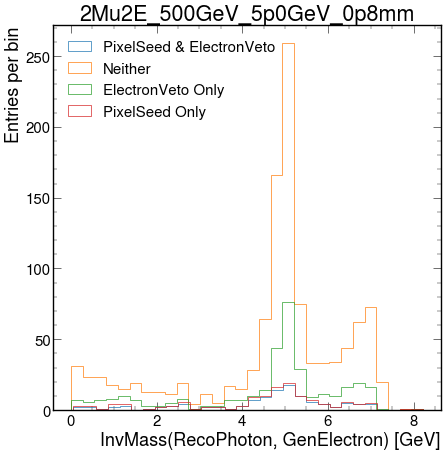

In [11]:
plt.hist(massesFullIso, bins=30, label = 'PixelSeed & ElectronVeto', histtype= 'step')
plt.hist(massesNoIso, bins=30, label = 'Neither', histtype= 'step')
plt.hist(massesNoPixel, bins=30, label = 'ElectronVeto Only', histtype= 'step')
plt.hist(massesNoVeto, bins=30, label = 'PixelSeed Only', histtype= 'step')
plt.legend()
plt.ylabel('Entries per bin')
plt.xlabel('InvMass(RecoPhoton, GenElectron) [GeV]')
plt.title('2Mu2E_500GeV_5p0GeV_0p8mm')

Text(0.5, 1.0, '2Mu2E_500GeV_5p0GeV_0p8mm')

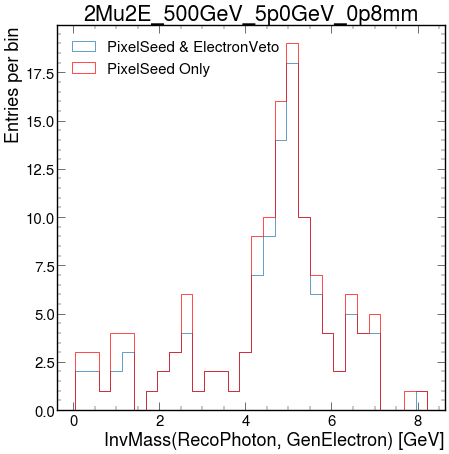

In [12]:
plt.hist(massesFullIso, bins=30, label = 'PixelSeed & ElectronVeto', histtype= 'step')
plt.hist(massesNoVeto, bins=30, label = 'PixelSeed Only', histtype= 'step', color = 'r')
plt.legend()
plt.ylabel('Entries per bin')
plt.xlabel('InvMass(RecoPhoton, GenElectron) [GeV]')
plt.title('2Mu2E_500GeV_5p0GeV_0p8mm')

Text(0.5, 1.0, '2Mu2E_500GeV_5p0GeV_0p8mm')

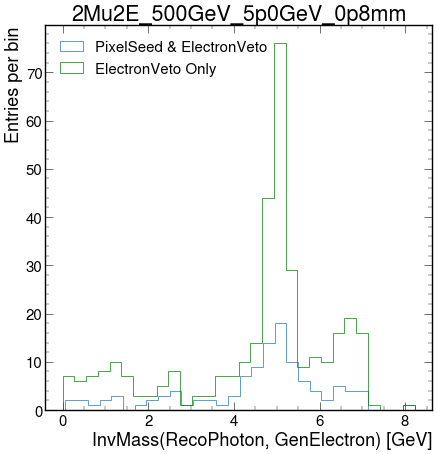

In [13]:
plt.hist(massesFullIso, bins=30, label = 'PixelSeed & ElectronVeto', histtype= 'step')
plt.hist(massesNoPixel, bins=30, label = 'ElectronVeto Only', histtype= 'step', color = 'g')
plt.legend()
plt.ylabel('Entries per bin')
plt.xlabel('InvMass(RecoPhoton, GenElectron) [GeV]')
plt.title('2Mu2E_500GeV_5p0GeV_0p8mm')

In [31]:
massCut = (massesNoIso < 6) & (massesNoIso > 4)

In [34]:
electronCut = (ak.num(genElectrons)==2)
genElectrons = genElectrons[electronCut]
evtMatchPhotons = PhotonsNoIso[electronCut]
evtMatchElectrons = Electrons[electronCut]
nonEmpty = ak.num(evtMatchPhotons) > 0
evtMatchPhotons = evtMatchPhotons[nonEmpty]
genElectrons = genElectrons[nonEmpty]
photon_genpartidx_deltar=[]
genpart_eta = genElectrons.eta
genpart_phi = genElectrons.phi
photon_eta = evtMatchPhotons.eta
photon_phi = evtMatchPhotons.phi
for genetas, genphis, etas, phis in zip(genpart_eta, genpart_phi, photon_eta, photon_phi):
    idx=[]
    for eta, phi in zip(etas, phis):
        deltar=deltaR(genetas, eta, genphis, phi)
        #print(deltar)
        if ak.min(deltar)<0.011:
            idx.append(ak.argmin(deltar))
        else:
            idx.append(-1)
    photon_genpartidx_deltar.append(idx)
masking_genmatched=(ak.Array(photon_genpartidx_deltar)!=-1)
genMatchedPhotons = evtMatchPhotons[masking_genmatched]
genMatchedGenElectrons = genElectrons[masking_genmatched]
pts = []
etas = []
phis = []
for i in range(len(photon_genpartidx_deltar)):
    if len(photon_genpartidx_deltar[i]) == 1:
        if photon_genpartidx_deltar[i][0] == -1: continue
        if photon_genpartidx_deltar[i][0] == 0:
            pts.append([genMatchedPhotons[i].pt[0], genElectrons[i].pt[1]])
            etas.append([genMatchedPhotons[i].eta[0], genElectrons[i].eta[1]])
            phis.append([genMatchedPhotons[i].phi[0], genElectrons[i].phi[1]])
        if photon_genpartidx_deltar[i][0] == 1:
            pts.append([genElectrons[i].pt[0], genMatchedPhotons[i].pt[0]])
            etas.append([genElectrons[i].eta[0], genMatchedPhotons[i].eta[0]])
            phis.append([genElectrons[i].eta[0], genMatchedPhotons[i].eta[0]])
masses = []
for i in range(len(etas)):
    masses.append(invariantMass(pts[i][0], pts[i][1], phis[i][0], phis[i][1], etas[i][0], etas[i][1]))
masses = np.array(masses)

In [44]:
remove_2_elements = (ak.num(masking_genmatched) == 1)

In [45]:
genMatchedPhotons = genMatchedPhotons[masking_genmatched & remove_2_elements]

In [53]:
nonEmptyGenMatchedPhotons = ak.num(genMatchedPhotons) > 0

In [54]:
genMatchedPhotons = genMatchedPhotons[nonEmptyGenMatchedPhotons]

In [56]:
massCut = (massesNoIso > 4) & (massesNoIso < 6)

In [57]:
genMatchedPhotons = genMatchedPhotons[massCut]

In [58]:
nonEmptyMass = ak.num(genMatchedPhotons) > 0

In [59]:
genMatchedPhotons = genMatchedPhotons[nonEmptyMass]

In [61]:
genMatchedPhotons.fields

['dEscaleDown',
 'dEscaleUp',
 'dEsigmaDown',
 'dEsigmaUp',
 'eCorr',
 'energyErr',
 'eta',
 'hoe',
 'mass',
 'mvaID',
 'mvaID_Fall17V1p1',
 'pfRelIso03_all',
 'pfRelIso03_chg',
 'phi',
 'pt',
 'r9',
 'sieie',
 'charge',
 'cutBased',
 'cutBased_Fall17V1Bitmap',
 'electronIdx',
 'jetIdx',
 'pdgId',
 'vidNestedWPBitmap',
 'electronVeto',
 'isScEtaEB',
 'isScEtaEE',
 'mvaID_WP80',
 'mvaID_WP90',
 'pixelSeed',
 'seedGain',
 'genPartIdx',
 'genPartFlav',
 'cleanmask',
 'electronIdxG',
 'genPartIdxG',
 'jetIdxG']

(0.0, 0.1)

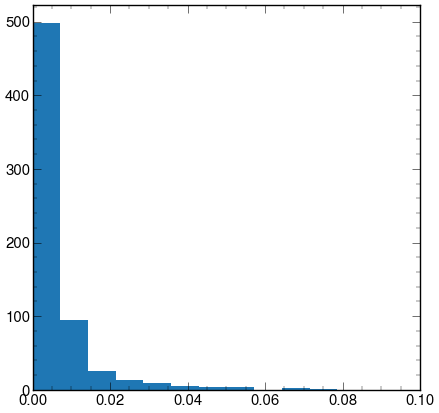

In [63]:
plt.hist(genMatchedPhotons.hoe, bins = 50)
plt.xlim(0,0.1)

(array([ 26., 479., 147.,   1.,   1.,   0.,   0.,   3.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 0.58349609,  0.77276367,  0.96203125,  1.15129888,  1.3405664 ,
         1.52983403,  1.71910155,  1.90836918,  2.0976367 ,  2.28690434,
         2.47617197,  2.66543937,  2.854707  ,  3.04397464,  3.23324227,
         3.42250967,  3.61177731,  3.80104494,  3.99031258,  4.17958021,
         4.36884785,  4.55811501,  4.74738264,  4.93665028,  5.12591791,
         5.31518555,  5.50445318,  5.69372082,  5.88298845,  6.07225609,
         6.26152325,  6.45079088,  6.64005852,  6.82932615,  7.01859379,
         7.20786142,  7.39712906,  7.58639669,  7.77566385,  7.96493149,
         8.1541996 ,  8.34346676,  8.53273392,  8.72200203,  8.91126919,
 

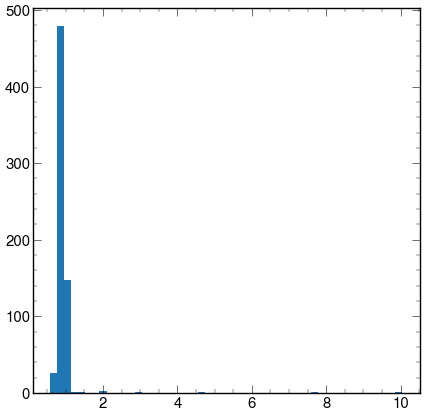

In [64]:
plt.hist(genMatchedPhotons.r9, bins = 50)